This file contains the entire pipeline for trading with the dataset

## 1. Parsing

In [20]:
import json
import pandas as pd
import warnings

def parse_lob(data_str):
    timestamps = []
    bids = []
    asks = []

    for i in range(len(data_str)):
        data_str_line = data_str[i].replace('Exch0', '"Exch0"')
        data_str_line = data_str_line.replace("'bid'", '"bid"')
        data_str_line = data_str_line.replace("'ask'", '"ask"')

        data_list = json.loads(data_str_line)

        # Extract exchange rate and exchange name
        exchange_rate = data_list[0]

        # Extract bid and ask data
        bid_data = data_list[2][0][1]
        ask_data = data_list[2][1][1]

        timestamps.append(exchange_rate)
        bids.append([bid_data])
        asks.append([ask_data])

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)

        # Create DataFrames once after the loop
        df = pd.DataFrame({
            'Timestamp': timestamps,
            'Bid': bids,
            'Ask': asks
        })

    # Concatenate nested lists within DataFrame columns
    df['Bid'] = df['Bid'].apply(lambda x: x[0])
    df['Ask'] = df['Ask'].apply(lambda x: x[0])

    return df

# Specify the path to your text file
file_path = '../LOBs/UoB_Set01_2025-03-03LOBs.txt'

# Example usage:
with open(file_path, 'r') as file:
    data_str = file.readlines()

result_df = parse_lob(data_str)
result_df.to_csv('lob_0303.csv', index=False)
print(result_df[:20])

    Timestamp                            Bid                             Ask
0       0.000                             []                              []
1       1.922                             []                      [[800, 4]]
2       2.387                     [[193, 2]]                      [[800, 4]]
3       2.449                     [[193, 2]]                      [[799, 4]]
4       2.945                     [[193, 2]]                      [[798, 4]]
5       3.720                     [[193, 2]]                      [[797, 4]]
6       4.030                     [[193, 2]]                      [[796, 4]]
7       4.247                     [[193, 2]]            [[748, 1], [796, 4]]
8       4.278                     [[193, 2]]            [[747, 4], [748, 1]]
9       4.619                     [[193, 2]]            [[746, 4], [748, 1]]
10      4.712                     [[193, 2]]  [[745, 4], [746, 4], [748, 1]]
11      4.743            [[193, 2], [18, 4]]  [[745, 4], [746, 4], [748, 1]]

## 2. merging

In [21]:
import pandas as pd

# Read the newly provided LOB data, adjusting for the updated indexing
lob_csv_path = 'lob_0303.csv'  # Updated file path

# Reading the updated LOB CSV file into a pandas DataFrame
lob_df = pd.read_csv(lob_csv_path)
lob_df.columns = ['Timestamp', 'Bid', 'Ask']
lob_df['Bid'] = lob_df['Bid'].apply(lambda x: eval(x) if x.startswith('[') else [])
lob_df['Ask'] = lob_df['Ask'].apply(lambda x: eval(x) if x.startswith('[') else [])

# Correcting tape data reading, including the first row as actual data
tape_csv_path = '../Tapes/UoB_Set01_2025-03-03tapes.csv'  # Tape file path remains the same
tape_df = pd.read_csv(tape_csv_path, header=None, skiprows=0)
tape_df.columns = ['Timestamp', 'Price', 'Volume']

tape_df['Price'] = tape_df['Price'].astype(int)
tape_df['Volume'] = tape_df['Volume'].astype(int)


def merge_data(tape_df, lob_df):
    # Initialize merged data list
    merged_data = []
    tape_idx, lob_idx = 0, 0

    while tape_idx < len(tape_df) and lob_idx < len(lob_df):
        # Get the current row of tape and LOB data
        tape_row = tape_df.iloc[tape_idx]
        lob_row = lob_df.iloc[lob_idx]
        bids, asks = lob_row['Bid'], lob_row['Ask']
        price, volume = int(tape_row['Price']), int(tape_row['Volume'])

        if tape_row['Timestamp'] < lob_row['Timestamp']:
            price_in_bid = any(price == bid[0] for bid in merged_data[-1][1])
            price_in_ask = any(price == ask[0] for ask in merged_data[-1][2])
            # Tape data comes before LOB data, insert tape data into new LOB row
            new_bid = [price, volume]
            new_ask = [price, volume]
            new_bids = merged_data[-1][1].copy()
            new_asks = (merged_data[-1][2].copy())
            if price_in_ask:
                new_bids.insert(0, new_bid)
            if price_in_bid:
                new_asks.insert(0, new_ask)
            merged_data.append([tape_row['Timestamp'], new_bids, new_asks])
            tape_idx += 1
        elif tape_row['Timestamp'] == lob_row['Timestamp']:
            # Check for price in bids or asks and adjust accordingly
            price_in_bid = any(price == bid[0] for bid in bids)
            price_in_ask = any(price == ask[0] for ask in asks)
            if price_in_bid:
                # If price is in bid, add transaction to start of ask list
                asks.insert(0, [price, volume])
            if price_in_ask:
                # If price is in ask, add transaction to start of bid list
                bids.insert(0, [price, volume])
            # Add the modified LOB row to merged data
            merged_data.append([lob_row['Timestamp'], bids, asks])
            tape_idx += 1
            lob_idx += 1
        else:
            # LOB data comes before tape data, add LOB data to merged data
            merged_data.append([lob_row['Timestamp'], bids, asks])
            lob_idx += 1

    # Handle remaining data in either dataset
    while tape_idx < len(tape_df):
        tape_row = tape_df.iloc[tape_idx]
        # Assuming inheritance of bid/ask from the last entry of merged_data if available
        last_bids, last_asks = merged_data[-1][1:3] if merged_data else ([], [])
        new_bid = [price, volume]
        new_ask = [price, volume]
        # Insert the transaction at the start of both bid and ask lists
        merged_data.append([tape_row['Timestamp'], [new_bid] + last_bids, [new_ask] + last_asks])
        tape_idx += 1

    while lob_idx < len(lob_df):
        lob_row = lob_df.iloc[lob_idx]
        bids = (lob_row['Bid'])
        asks = (lob_row['Ask'])
        merged_data.append([lob_row['Timestamp'], bids, asks])
        lob_idx += 1

    # Convert the merged data to a DataFrame
    merged_df = pd.DataFrame(merged_data, columns=['Timestamp', 'Bid', 'Ask'])
    return merged_df


# Merge the tape and LOB data into a single DataFrame
merged_df = merge_data(tape_df, lob_df)
merged_df.to_csv('merged_lob_0303.csv', index=False)


## 3. ARIMA

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the dataset
file_path = '../Tapes/UoB_Set01_2025-03-03tapes.csv'  # Update this to the path of your CSV file
data = pd.read_csv(file_path, header=None, names=['seconds', 'transaction_price', 'number_of_transactions'])

# Convert seconds to a timedelta and then to a datetime starting from a reference point
data['timestamp'] = pd.to_timedelta(data['seconds'], unit='s') + pd.Timestamp('2025-03-03 00:00')
data.set_index(keys='timestamp', inplace=True)

# Resample the transaction prices to get mean values per second
resampled_data = data['transaction_price'].resample('1S').mean()

# Forward-fill the missing values
resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()

split_point = int(len(resampled_data_ffill) * 0.8)
train_data = resampled_data_ffill[:split_point].asfreq('S')
test_data = resampled_data_ffill[split_point:].asfreq('S')

/var/folders/1f/gqtm7m2d6mq4y_35lmr6nxrc0000gn/T/ipykernel_50431/4163818542.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

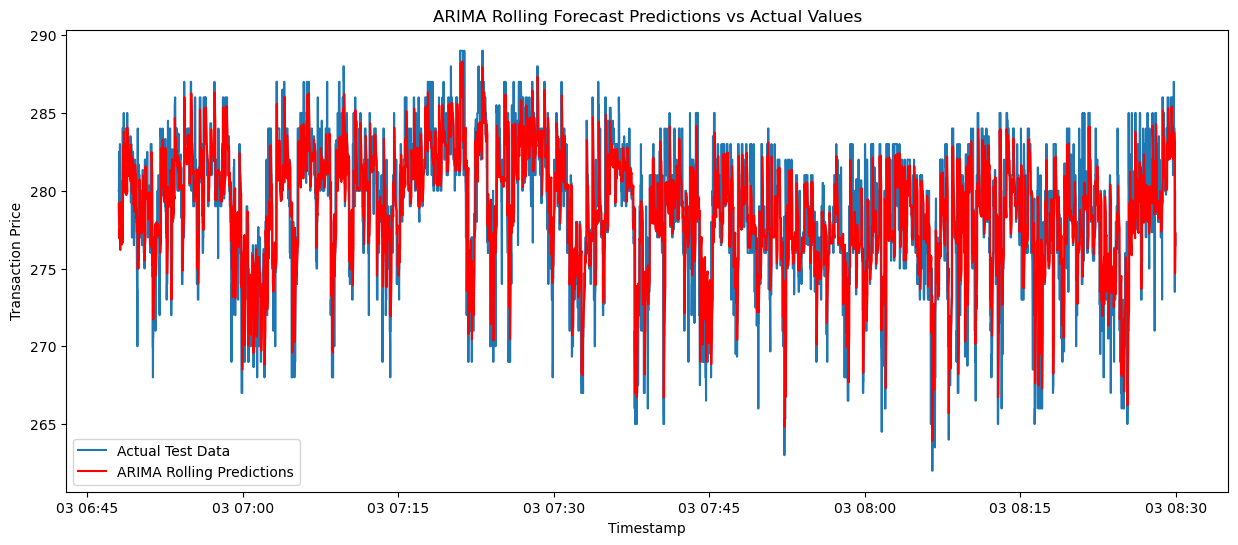

In [23]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming train_data and test_data are pandas Series with datetime indices

# Set the frequency of the time series data
train_data = train_data.asfreq('S')
test_data = test_data.asfreq('S')

# Ensure the indices are monotonically increasing
train_data = train_data.sort_index()
test_data = test_data.sort_index()

# Check for duplicates and remove them if necessary
train_data = train_data[~train_data.index.duplicated(keep='first')]

# Define the frequency of model updates
update_frequency = 5  # Retrain the model every 5 steps

# Initialize the history with the training data
history = train_data.copy()

# Prepare a list to store predictions
predictions = []

# Preallocate the space for performance optimization
predictions = [None] * len(test_data)

# Start rolling forecast with updates every 5 steps
for t in range(0, len(test_data), update_frequency):
    # Fit the ARIMA model on the current history
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    
    # Make predictions for the next 5 steps
    next_steps_predictions = model_fit.forecast(steps=update_frequency)
    
    # Store the predictions
    if t + update_frequency < len(test_data):
        predictions[t:t+update_frequency] = next_steps_predictions
    else:
        predictions[t:] = next_steps_predictions[:len(test_data)-t]
    
    # Update the history with the new observations
    if t + update_frequency < len(test_data):
        new_history = test_data[t:t+update_frequency]
        history = pd.concat([history, new_history])
    print(t)

print(len(predictions))
print(len(test_data.index))
# Convert predictions to a Series for easy plotting
predictions_series = pd.Series(predictions, index=test_data.index)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(predictions_series.index, predictions_series, label='ARIMA Rolling Predictions', color='red')
plt.title('ARIMA Rolling Forecast Predictions vs Actual Values')
plt.xlabel('Timestamp')
plt.ylabel('Transaction Price')
plt.legend()
plt.show()


In [24]:
# calculate RMSE and save the prediction into a csv
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions_series))
print(f"Root Mean Squared Error (RMSE) of Predictions: {rmse}")

# Save the predictions to a CSV file
predictions_series.to_csv('arima_111_0303_predictions.csv', header=['transaction_price'])

Root Mean Squared Error (RMSE) of Predictions: 3.1869735208401946


## 4. Simulation

In [27]:
import pandas as pd
import ast  # To safely evaluate string representation of lists


# Load the datasets
tape_data = pd.read_csv('arima_111_0103_predictions.csv')
lob_data = pd.read_csv('merged_lob_0103.csv')

# Display the first few rows of each dataset to understand their structure
tape_data.head(), lob_data.head()

# Convert 'timestamp' in tape_data to seconds since the start of the day
tape_data['timestamp'] = pd.to_datetime(tape_data['timestamp'])
tape_data['timestamp_seconds'] = tape_data['timestamp'].dt.hour * 3600 + tape_data['timestamp'].dt.minute * 60 + tape_data['timestamp'].dt.second


def momentum_trading_with_pointers(tape_data, lob_data, initial_capital):
    capital = initial_capital
    position = 0  # No position initially

    tape_index = 0
    lob_index = 0
    tape_len = len(tape_data)
    lob_len = len(lob_data)

    while tape_index < tape_len - 1 and lob_index < lob_len:
        # Current positions in both datasets
        tape_ts = tape_data['timestamp_seconds'].iloc[tape_index]
        lob_ts = lob_data['Timestamp'].iloc[lob_index]

        # Move LOB pointer to match or exceed tape timestamp
        # while lob_index < lob_len - 1 and lob_data['Timestamp'].iloc[lob_index + 1] <= tape_ts:
        #     lob_index += 1
        if lob_index < lob_len - 1 and lob_ts <= tape_ts:
            lob_index += 1
        elif tape_data['timestamp_seconds'].iloc[tape_index + 1] > lob_data['Timestamp'].iloc[lob_index] > tape_ts:

            # If timestamps match, execute trading logic
            # if lob_ts == tape_ts:
            current_price = tape_data['transaction_price'].iloc[tape_index]
            next_price = tape_data['transaction_price'].iloc[tape_index + 1] if tape_index + 1 < tape_len else current_price

            # Parse bid and ask lists
            current_bids = ast.literal_eval(lob_data['Bid'].iloc[lob_index])
            current_asks = ast.literal_eval(lob_data['Ask'].iloc[lob_index])

            # Determine the best bid and ask
            if current_bids:
                best_bid = max(current_bids, key=lambda x: x[0])
                best_bid_price, best_bid_volume = best_bid
            else:
                best_bid_price, best_bid_volume = 0, 0

            if current_asks:
                best_ask = min(current_asks, key=lambda x: x[0])
                best_ask_price, best_ask_volume = best_ask
            else:
                best_ask_price, best_ask_volume = float('inf'), 0

            # Buy if predicted next price is higher than current and best ask
            if next_price > current_price and next_price > best_ask_price:
                buy_volume = 1  # Simplified to always trade one unit
                capital -= buy_volume * best_ask_price
                position += buy_volume

            # Sell if predicted next price is lower than current and best bid
            elif next_price < current_price and position > 0 and best_bid_price > next_price:
                sell_volume = 1  # Simplified to always trade one unit
                capital += sell_volume * best_bid_price
                position -= sell_volume

            lob_index += 1
        else:
            tape_index += 1

    # Final sell off all positions at last known bid price
    if position > 0 and ast.literal_eval(lob_data['Bid'].iloc[lob_index]):
        final_bid = max(ast.literal_eval(lob_data['Bid'].iloc[lob_index]), key=lambda x: x[0])
        final_price = final_bid[0]
        capital += position * final_price

    return capital


initial_capital = 10000  # For example, $10,000

# Run the improved trading simulator with the double pointer approach
final_capital = momentum_trading_with_pointers(tape_data, lob_data, initial_capital)
print(final_capital)

77582
